# GROUP 1
## *Vulgarity Detection in a sentence using RNN*


---



## Members:

| Name | ID |
|--|--|
| Rokibul Islam | 011181102 |
|Tahsin Habib Brinto |011181107|
|Chion Ghosh |011181110|
|Hasibul Hasan |011181117|



---



> CSE 416 (A) // Project

In [ ]:
import re
import string

import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
text = []
labels = []
with open('/content/drive/MyDrive/Colab Notebooks/pattern_project/_warner.txt', 'r') as f:
  with open('/content/drive/MyDrive/Colab Notebooks/pattern_project/data.csv', 'w', newline= '') as data:
    d = f.readlines()
    instances = [(d[i],d[i+1]) for i in range(0,len(d),3)]
    for instance in instances:
      label_class = instance[0]
      feature = instance[1]

      if 'notAbusive' in label_class:
        label = 0
      else:
        label = 1

      text.append(feature.replace('\n', ''))
      labels.append(label)

    df = pd.DataFrame(list(zip(text, labels)), columns=['text', 'target'])

In [ ]:
df.head()
df.shape

(1280, 2)

#Text Cleaning and Preprocessing

In [ ]:
stop = set(stopwords.words("english"))

def remove_stopwords(text):
    filtered_words = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(filtered_words)

def remove_URL(text):
    url = re.compile(r"https?://\S+|www\.\S+")
    return url.sub(r"", text)

def remove_punct(text):
    translator = str.maketrans("", "", string.punctuation)
    return text.translate(translator)
  
def remove_emoji(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                            "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [ ]:
df["text"] = df.text.map(remove_stopwords)
df["text"] = df.text.map(remove_URL)
df["text"] = df.text.map(remove_punct)
df["text"] = df.text.map(remove_emoji)

In [ ]:
from collections import Counter

# Count unique words
def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count

counter = counter_word(df.text)

In [ ]:
num_unique_words = len(counter)

#Over sampling our data as it's imbalanced
### Using SMOTE (Synthetic Minority Over-sampling Technique)

In [ ]:
from sklearn.model_selection import train_test_split
X = df.text
y = df.target

train_sentences, val_sentences, train_labels, val_labels = train_test_split(X, y, train_size=0.8, random_state=911, stratify=y)

In [ ]:
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import SMOTE


textclassifier =Pipeline([
  ('vect', CountVectorizer()),
   ('tfidf', TfidfTransformer()),
   ('smote', SMOTE(random_state=12)),
   ('mnb', MultinomialNB(alpha =0.1))
])

textclassifier.fit(train_sentences, train_labels)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('smote', SMOTE(random_state=12)),
                ('mnb', MultinomialNB(alpha=0.1))])

# Tokenizing text

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=num_unique_words, oov_token='<OOV>')
tokenizer.fit_on_texts(train_sentences) # fitting only to train data

In [ ]:
# each word has unique index
word_index = tokenizer.word_index

# Test data (Manual)

In [ ]:
# test_sentances = ['When the snows fall and the white winds blow, the lone wolf dies but the pack survives.']


# test_sentances =  [remove_stopwords(x) for x in test_sentances]
# test_sentances =  [remove_URL(x) for x in test_sentances]
# test_sentances =  [remove_emoji(x) for x in test_sentances]
# test_sentances =  [remove_punct(x) for x in test_sentances]



## Generating sequesnces for the train and validation data

In [ ]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)
val_sequences = tokenizer.texts_to_sequences(val_sentences)
# test_sequences = tokenizer.texts_to_sequences(test_sentances)

#Padding
```tf.keras.layers.TextVectorization``` encoder could have been used. It does all the steps including preprocessing, vocabulary sequence --> padding and embedding

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Max number of words in a sequence
max_length = 40

train_padded = pad_sequences(train_sequences, maxlen=max_length, padding="post", truncating="post")
val_padded = pad_sequences(val_sequences, maxlen=max_length, padding="post", truncating="post")
# test_padded = pad_sequences(test_sequences, maxlen=max_length, padding="post", truncating="post")
train_padded.shape, val_padded.shape

((1024, 40), (256, 40))

#Creating LSTM Model

In [ ]:
from tensorflow.keras import layers

model = keras.models.Sequential()
model.add(layers.Embedding(num_unique_words, 32 , input_length=max_length))

model.add(layers.LSTM(64, dropout=0.1))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 40, 32)            262528    
                                                                 
 lstm_2 (LSTM)               (None, 64)                24832     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 287,425
Trainable params: 287,425
Non-trainable params: 0
_________________________________________________________________


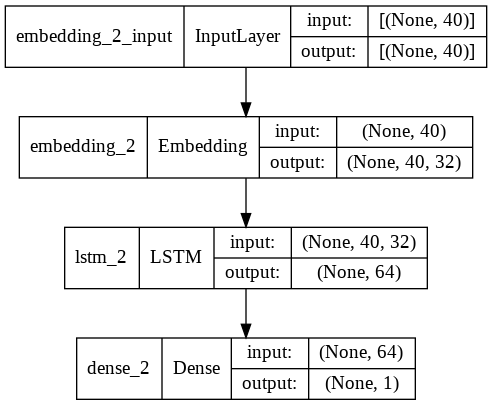

In [ ]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras import metrics

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics = ['Recall'])
              
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
hist = model.fit(train_padded, train_labels, epochs=100, validation_data=(val_padded, val_labels), verbose=2)

Epoch 1/100
32/32 - 4s - loss: 0.4772 - recall: 0.0411 - val_loss: 0.4083 - val_recall: 0.0000e+00 - 4s/epoch - 123ms/step
Epoch 2/100
32/32 - 1s - loss: 0.3744 - recall: 0.0068 - val_loss: 0.3867 - val_recall: 0.0270 - 797ms/epoch - 25ms/step
Epoch 3/100
32/32 - 1s - loss: 0.2677 - recall: 0.4521 - val_loss: 0.3502 - val_recall: 0.6216 - 796ms/epoch - 25ms/step
Epoch 4/100
32/32 - 1s - loss: 0.1029 - recall: 0.9247 - val_loss: 0.4055 - val_recall: 0.3784 - 806ms/epoch - 25ms/step
Epoch 5/100
32/32 - 1s - loss: 0.1733 - recall: 0.9726 - val_loss: 0.7819 - val_recall: 0.7838 - 847ms/epoch - 26ms/step
Epoch 6/100
32/32 - 1s - loss: 0.2012 - recall: 0.5000 - val_loss: 0.5134 - val_recall: 0.0000e+00 - 823ms/epoch - 26ms/step
Epoch 7/100
32/32 - 1s - loss: 0.2671 - recall: 0.0000e+00 - val_loss: 0.4739 - val_recall: 0.0000e+00 - 814ms/epoch - 25ms/step
Epoch 8/100
32/32 - 1s - loss: 0.4210 - recall: 0.0000e+00 - val_loss: 0.4147 - val_recall: 0.0000e+00 - 850ms/epoch - 27ms/step
Epoch 9/10

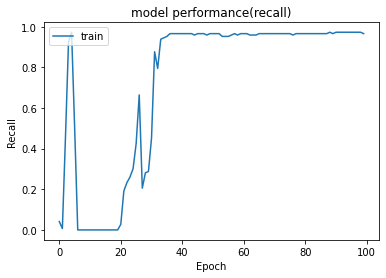

In [ ]:
import matplotlib.pyplot as plt

hist.history
plt.plot(hist.history['recall'])
plt.title('model performance(recall)')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
predictions = model.predict(val_padded)
predictions = [1 if p > 0.5 else 0 for p in predictions]

#Classification Report

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(val_labels, predictions))


              precision    recall  f1-score   support

           0       0.92      0.93      0.92       219
           1       0.54      0.51      0.53        37

    accuracy                           0.87       256
   macro avg       0.73      0.72      0.73       256
weighted avg       0.86      0.87      0.87       256



In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(val_labels, predictions)
recall = recall_score(val_labels, predictions)
precision = precision_score(val_labels, predictions)
f1 = f1_score(val_labels, predictions)

print(f'Accuracy: {accuracy}')
print(f'F1_Score: {f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

Accuracy: 0.8671875
F1_Score: 0.5277777777777778
Precision: 0.5428571428571428
Recall: 0.5135135135135135


# References and Doccumentations for later use

 1. https://www.coursera.org/learn/natural-language-processing-tensorflow/home/welcome
 2. https://www.tensorflow.org/text/tutorials/text_classification_rnn
 3. https://www.youtube.com/watch?v=fNxaJsNG3-s&list=PLQY2H8rRoyvzDbLUZkbudP-MFQZwNmU4S
 4. https://www.youtube.com/watch?v=aircAruvnKk
 5. https://github.com/python-engineer/tensorflow-course
 6. https://keras.io/api/layers/recurrent_layers/bidirectional/
 7. https://www.analyticsvidhya.com/blog/2021/03/introduction-to-long-short-term-memory-lstm/
 8. https://realpython.com/python-keras-text-classification/
 9. Dataset: https://heidata.uni-heidelberg.de/dataset.xhtml;jsessionid=906ce23d249bdd3ead0265954f80?persistentId=doi%3A10.11588%2Fdata%2FMKPEYV&version=&q=&fileTypeGroupFacet=%22Archive%22&fileTag=&fileSortField=&fileSortOrder=